# Chapter 9  Support Vector Machines

- [Lab 9.6.1 Support Vector Classifier](#lab-9.6.1)
- [Lab 9.6.2 Support Vector Machine](#lab-9.6.2)
- [Lab 9.6.3 ROC Curves](#lab-9.6.3)
- [Lab 9.6.4 SVM with Multiple Classes](#lab-9.6.4)
- [Lab 9.6.5 Application to Gene Expression Data](#lab-9.6.5)

### Imports and Configurations

In [1]:
# Use rpy2 for loading R datasets
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import data as rdata
from rpy2.robjects import pandas2ri

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# scikit-learn
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Visulization
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')

*SVC plot function.**

In [2]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

<a id='lab-9.6.1'></a>

### Lab 9.6.1 Support Vector Classifier

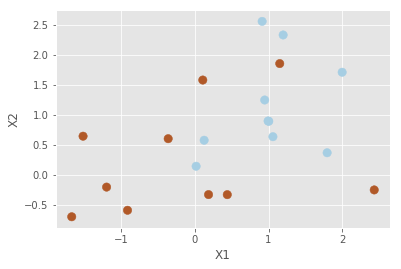

In [3]:
# Generating random data: 20 observations of 2 features and divide into two classes.
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([1,-1], 10)

X[y == -1] = X[y == -1] +1
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [4]:
svc = SVC(C=1, kernel='linear')
svc.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

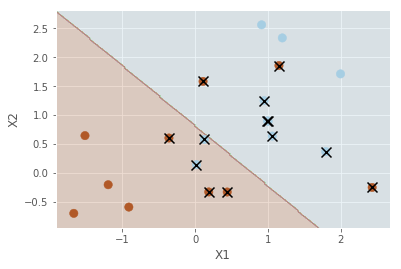

Number of support vectors:  13


In [5]:
plot_svc(svc, X, y)

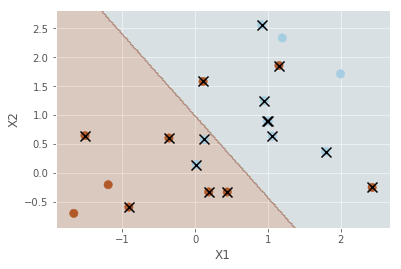

Number of support vectors:  16


In [6]:
# When using a smaller cost parameter (C=0.1) the margin is wider, resulting in more support vectors.
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)
plot_svc(svc2, X, y)

In [7]:
# Select the optimal C parameter by cross-validation
tuning_parms = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuning_parms, cv=10, scoring='accuracy')
clf.fit(X, y)
pd.DataFrame(clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.80,0.244949,{'C': 0.001}
1,0.80,0.244949,{'C': 0.01}
2,0.80,0.244949,{'C': 0.1}
3,0.75,0.335410,{'C': 1}
4,0.75,0.335410,{'C': 5}
5,0.75,0.335410,{'C': 10}
6,0.75,0.335410,{'C': 100}


In [8]:
# Best parameter according to GridSearchCV. 
clf.best_params_

{'C': 0.001}

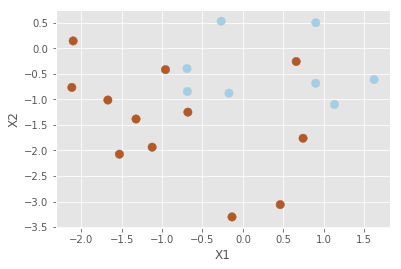

In [9]:
# Generating test data
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = np.random.choice([-1,1], 20)
X_test[y_test == 1] = X_test[y_test == 1] -1

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [10]:
# Prediction with C = 0.1
y_pred = svc2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc.classes_, columns=svc.classes_)

,-1,1
-1,2,6
1,0,12


In [11]:
# SVC with C = 0.001
svc3 = SVC(C=0.001, kernel='linear')
svc3.fit(X, y)
y_pred = svc3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc3.classes_, columns=svc3.classes_)

,-1,1
-1,2,6
1,0,12


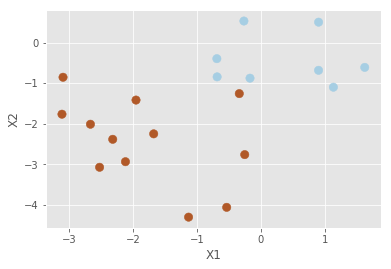

In [12]:
# Changing the test data so that the classes are really seperable with a hyperplane.
X_test[y_test == 1] = X_test[y_test == 1] -1
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

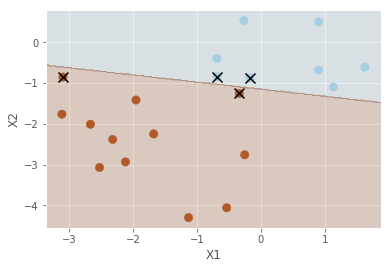

Number of support vectors:  4


In [13]:
svc4 = SVC(C=10.0, kernel='linear')
svc4.fit(X_test, y_test)
plot_svc(svc4, X_test, y_test)

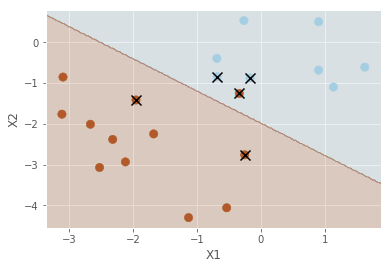

Number of support vectors:  5


In [14]:
# Increase the margin: 1 mis-classfication. Increased bias, lower variance.
svc5 = SVC(C=1, kernel='linear')
svc5.fit(X_test, y_test)
plot_svc(svc5, X_test, y_test)

<a id='lab-9.6.2'></a>

### Lab 9.6.2 Support Vector Machine

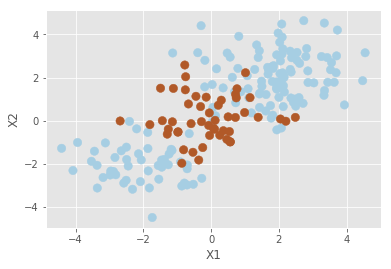

In [15]:
# Generate test data
np.random.seed(8)
X = np.random.randn(200,2)
X[:100] = X[:100] +2
X[101:150] = X[101:150] -2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=2)
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [16]:
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

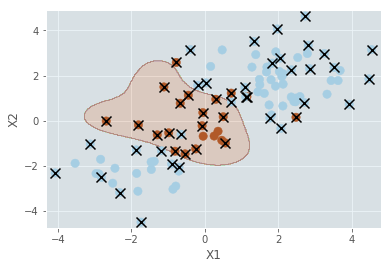

Number of support vectors:  51


In [17]:
plot_svc(svm, X_train, y_train)

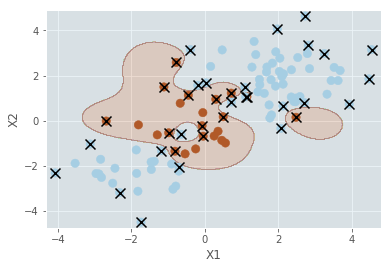

Number of support vectors:  36


In [18]:
# Increasing C parameter, allowing more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)
plot_svc(svm2, X_train, y_train)

In [19]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy')
clf.fit(X_train, y_train)
pd.DataFrame(clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.77,0.031286,"{'C': 0.01, 'gamma': 0.5}"
1,0.77,0.031286,"{'C': 0.01, 'gamma': 1}"
2,0.77,0.031286,"{'C': 0.01, 'gamma': 2}"
3,0.77,0.031286,"{'C': 0.01, 'gamma': 3}"
4,0.77,0.031286,"{'C': 0.01, 'gamma': 4}"
5,0.77,0.031286,"{'C': 0.1, 'gamma': 0.5}"
6,0.77,0.031286,"{'C': 0.1, 'gamma': 1}"
7,0.77,0.031286,"{'C': 0.1, 'gamma': 2}"
8,0.77,0.031286,"{'C': 0.1, 'gamma': 3}"
9,0.77,0.031286,"{'C': 0.1, 'gamma': 4}"


In [20]:
clf.best_params_

{'C': 1, 'gamma': 0.5}

In [21]:
confusion_matrix(y_test, clf.best_estimator_.predict(X_test))

array([[67,  6],
       [ 9, 18]])

In [22]:
# 15% of test observations misclassified
clf.best_estimator_.score(X_test, y_test)

0.84999999999999998

<a id='lab-9.6.3'></a>

### Lab 9.6.3 ROC Curves

In [23]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
# More flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=50, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

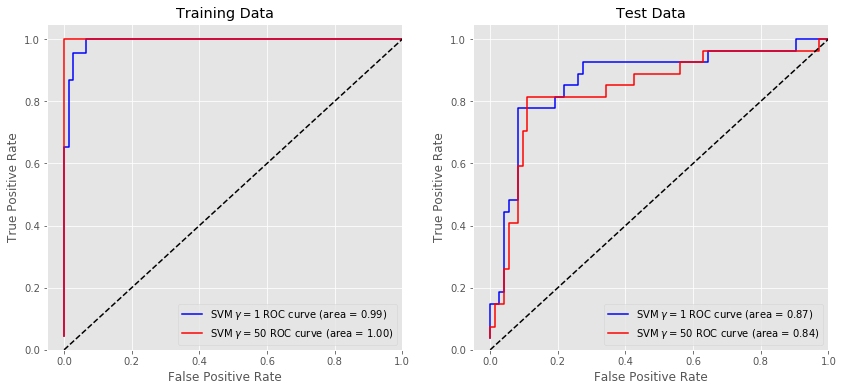

In [25]:
y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax2.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

<a id='lab-9.6.4'></a>

### Lab 9.6.4 SVM with Multiple Classes

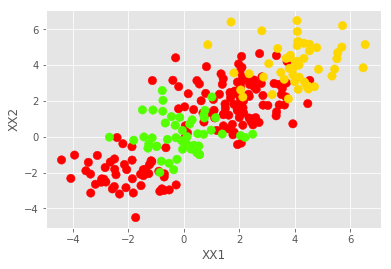

In [26]:
# Adding a third class of observations
np.random.seed(8)
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy ==0] = XX[yy == 0] +4

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2');

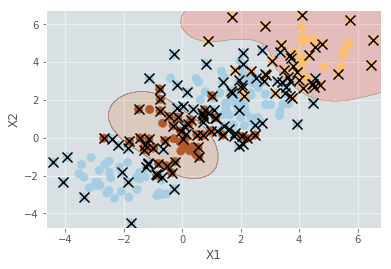

Number of support vectors:  133


In [27]:
svm5 = SVC(C=1, kernel='rbf')
svm5.fit(XX, yy)
plot_svc(svm5, XX, yy)

<a id='lab-9.6.5'></a>

### Lab 9.6.5 Application to Gene Expression Data

In [28]:
# Load Khan data set from  R ISLR package
islr = importr('ISLR')
khan_rdf = rdata(islr).fetch('Khan')['Khan']
list(khan_rdf.names)

['xtrain', 'xtest', 'ytrain', 'ytest']

In [29]:
# Assign X, y train and test set
X_train = pandas2ri.ri2py(khan_rdf[0])
X_test = pandas2ri.ri2py(khan_rdf[1])
y_train = pandas2ri.ri2py(khan_rdf[2]).astype(int)
y_test = pandas2ri.ri2py(khan_rdf[3]).astype(int)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(63, 2308)
(63,)
(20, 2308)
(20,)


In [30]:
# y_train counts
pd.Series(y_train).value_counts()

2    23
4    20
3    12
1     8
dtype: int64

In [31]:
# y_test counts
pd.Series(y_test).value_counts()

3    6
2    6
4    5
1    3
dtype: int64

In [32]:
# This model gives identical results to the svm() of the R package e1071, also based on libsvm library.
svc = SVC(kernel='linear')

# This model is based on liblinear library and gives 100 score on the test data. 
#svc = LinearSVC()

svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
# Traing CM
cm = confusion_matrix(y_train, svc.predict(X_train))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       1   2   3   4
Predicted               
1          8   0   0   0
2          0  23   0   0
3          0   0  12   0
4          0   0   0  20


In [34]:
# Prediction and test CM
cm = confusion_matrix(y_test, svc.predict(X_test))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       1  2  3  4
Predicted            
1          3  0  0  0
2          0  6  2  0
3          0  0  4  0
4          0  0  0  5
